In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [11]:
participation = pd.read_csv('data_raw/bfs_national_council_election_participation_2019.csv', sep=';')
results = pd.read_csv('data_raw/bfs_national_council_election_results_2019.csv', sep=';')
lists = pd.read_csv('data_raw/bfs_national_council_election_lists_2019.csv', sep=';')

In [12]:
# --- CHOOSE ELECTION YEAR ---
ELECTION_YEAR = 2019 # Modify this for other election years

# Filter data for the chosen election year
participation_year = participation[participation['wahl_jahr'] == ELECTION_YEAR].copy()
results_year = results[results['wahl_jahr'] == ELECTION_YEAR].copy()
lists_year_original = lists[lists['wahl_jahr'] == ELECTION_YEAR].copy() # Keep original lists data separate

print(f"--- Data for Election Year: {ELECTION_YEAR} ---")

# Define seats per canton. IMPORTANT: Ensure this is correct for ELECTION_YEAR.
# Keys are 'kanton_nummer'. This is for the Swiss National Council.
seats_per_canton_dict = {
    1: 35, 2: 24, 3: 9, 4: 1, 5: 4, 6: 1, 7: 1, 8: 1, 9: 3, 10: 7,
    11: 6, 12: 5, 13: 7, 14: 2, 15: 1, 16: 1, 17: 12, 18: 5, 19: 16,
    20: 6, 21: 8, 22: 19, 23: 8, 24: 4, 25: 12, 26: 2
}
print(f"Total National Council seats to be distributed: {sum(seats_per_canton_dict.values())}")

--- Data for Election Year: 2019 ---
Total National Council seats to be distributed: 200


In [13]:
def apply_100_percent_turnout_simulation(current_lists_df, results_df, participation_df):
    """
    Adjusts list votes to simulate 100% voter turnout at the commune level.
    The preferences of actual voters in each commune are extrapolated to non-voters
    in that same commune. The total adjusted votes for a party in a canton are then
    redistributed among that party's lists proportionally to their original vote shares.

    Args:
        current_lists_df (pd.DataFrame): The DataFrame with list data for the election year.
        results_df (pd.DataFrame): DataFrame with party results at the commune level.
        participation_df (pd.DataFrame): DataFrame with voter participation data at the commune level.

    Returns:
        pd.DataFrame: A new DataFrame based on current_lists_df with an updated 'votes_to_use' column.
    """
    print("\n--- Applying 100% Turnout Simulation (commune-level adjustment) ---")
    # Merge commune-level party results with participation data
    commune_votes_details = results_df.merge(
        participation_df[['gemeinde_nummer', 'kanton_nummer', 'wahlberechtigte', 'gueltige_wahlzettel']],
        on=['gemeinde_nummer', 'kanton_nummer'],
        how='left'
    )
    commune_votes_details.dropna(subset=['wahlberechtigte', 'gueltige_wahlzettel'], inplace=True)

    # Calculate party votes as if all eligible voters in a commune voted
    commune_votes_details['adjusted_stimmen_partei'] = np.where(
        commune_votes_details['gueltige_wahlzettel'] > 0,
        (commune_votes_details['stimmen_partei'] / commune_votes_details['gueltige_wahlzettel']) * commune_votes_details['wahlberechtigte'],
        0
    ).round() # Rounding here to avoid tiny fractional votes before summing

    # Sum these adjusted party votes at the cantonal level
    canton_party_adjusted_total_votes = commune_votes_details.groupby(
        ['kanton_nummer', 'partei_id']
    )['adjusted_stimmen_partei'].sum().reset_index()

    # Get the sum of original list votes for each party in each canton from the input list data
    original_party_canton_list_sum = current_lists_df.groupby(
        ['kanton_nummer', 'partei_id']
    )['stimmen_liste'].sum().reset_index().rename(columns={'stimmen_liste': 'original_total_list_stimmen_for_party_canton'})

    # Work on a copy for modification
    simulated_lists_df = current_lists_df.copy()

    # Merge these totals into the lists_votes_processed DataFrame
    simulated_lists_df = simulated_lists_df.merge(
        canton_party_adjusted_total_votes, on=['kanton_nummer', 'partei_id'], how='left'
    )
    simulated_lists_df = simulated_lists_df.merge(
        original_party_canton_list_sum, on=['kanton_nummer', 'partei_id'], how='left'
    )
    simulated_lists_df['adjusted_stimmen_partei'] = simulated_lists_df['adjusted_stimmen_partei'].fillna(0)
    simulated_lists_df['original_total_list_stimmen_for_party_canton'] = simulated_lists_df['original_total_list_stimmen_for_party_canton'].fillna(0)

    # Distribute the total adjusted party votes (for a canton) among its lists proportionally
    simulated_lists_df['votes_to_use'] = np.where(
        simulated_lists_df['original_total_list_stimmen_for_party_canton'] > 0,
        (simulated_lists_df['stimmen_liste'] / simulated_lists_df['original_total_list_stimmen_for_party_canton']) * simulated_lists_df['adjusted_stimmen_partei'],
        0
    ).round().astype(int) # Final votes should be integers

    return simulated_lists_df


# Initialize lists_votes_processed with original list votes
lists_votes_processed = lists_year_original.copy()
lists_votes_processed['votes_to_use'] = lists_votes_processed['stimmen_liste']
print(f"\n--- Using original 'stimmen_liste' for vote allocation. ---")

# --- To activate 100% turnout simulation, uncomment the following line: ---
# lists_votes_processed = apply_100_percent_turnout_simulation(lists_year_original, results_year, participation_year)


# Prepare identifiers for list connections and unique lists
# NaN values are replaced with unique strings to treat them as distinct "no connection" groups
lists_votes_processed['lv_group'] = lists_votes_processed['liste_verbindung'].fillna(
    pd.Series(lists_votes_processed.index).apply(lambda x: f'no_lv_{x}')
)
lists_votes_processed['luv_group'] = lists_votes_processed['liste_unterlistenverbindung'].fillna(
    pd.Series(lists_votes_processed.index).apply(lambda x: f'no_luv_{x}')
)
lists_votes_processed['list_unique_id'] = lists_votes_processed['kanton_nummer'].astype(str) + "_" + lists_votes_processed['liste_nummer_bfs'].astype(str)


--- Using original 'stimmen_liste' for vote allocation. ---


In [14]:
def allocate_seats_dhondt(entity_votes_dict, num_seats_to_allocate):
    """
    Allocates seats using the D'Hondt method.
    Divides votes by successive integers (1, 2, 3, ...). Tends to favor larger parties.

    Args:
        entity_votes_dict (dict): {'entity_id': votes}.
        num_seats_to_allocate (int): Total seats to distribute.

    Returns:
        dict: {'entity_id': allocated_seats}.
    """
    if num_seats_to_allocate == 0 or not entity_votes_dict or sum(entity_votes_dict.values()) == 0:
        return {entity_id: 0 for entity_id in entity_votes_dict}

    allocated_seats = {entity_id: 0 for entity_id in entity_votes_dict}
    quotients = []
    for entity_id, votes in entity_votes_dict.items():
        if votes > 0:
            for i in range(1, num_seats_to_allocate + 20):
                quotients.append({'id': entity_id, 'quotient': votes / i, 'original_votes': votes})

    quotients_df = pd.DataFrame(quotients).sort_values(by=['quotient', 'original_votes'], ascending=[False, False])

    for i in range(min(num_seats_to_allocate, len(quotients_df))):
        allocated_seats[quotients_df.iloc[i]['id']] += 1
    return allocated_seats

def allocate_seats_sainte_lague(entity_votes_dict, num_seats_to_allocate):
    """
    Allocates seats using the Sainte-Laguë method (standard version).
    Divides votes by successive odd integers (1, 3, 5, ...). More proportional than D'Hondt.

    Args:
        entity_votes_dict (dict): {'entity_id': votes}.
        num_seats_to_allocate (int): Total seats to distribute.

    Returns:
        dict: {'entity_id': allocated_seats}.
    """
    if num_seats_to_allocate == 0 or not entity_votes_dict or sum(entity_votes_dict.values()) == 0:
        return {entity_id: 0 for entity_id in entity_votes_dict}

    allocated_seats = {entity_id: 0 for entity_id in entity_votes_dict}
    quotients = []
    for entity_id, votes in entity_votes_dict.items():
        if votes > 0:
            for i in range(num_seats_to_allocate + 20):
                divisor = 2 * i + 1
                quotients.append({'id': entity_id, 'quotient': votes / divisor, 'original_votes': votes})

    quotients_df = pd.DataFrame(quotients).sort_values(by=['quotient', 'original_votes'], ascending=[False, False])

    for i in range(min(num_seats_to_allocate, len(quotients_df))):
        allocated_seats[quotients_df.iloc[i]['id']] += 1
    return allocated_seats

# --- Select the seat allocation function ---
seat_allocator = allocate_seats_dhondt
# seat_allocator = allocate_seats_sainte_lague
# Add other custom allocation functions here and assign to seat_allocator

print(f"Using {seat_allocator.__name__} for seat allocation.")

Using allocate_seats_dhondt for seat allocation.


In [15]:
# This cell performs the hierarchical seat allocation within each canton based on selected method and votes.

final_seat_allocations_list = [] # Stores the final seat count for each winning list

for k_num, seats_in_canton in seats_per_canton_dict.items():
    if seats_in_canton == 0: continue # Skip cantons with no seats

    canton_lists_data = lists_votes_processed[lists_votes_processed['kanton_nummer'] == k_num].copy()
    if canton_lists_data.empty: continue

    # Level 1: Allocate seats to main list connections (lv_group)
    main_conn_votes = canton_lists_data.groupby('lv_group')['votes_to_use'].sum().to_dict()
    seats_for_main_conn = seat_allocator(main_conn_votes, seats_in_canton)

    # Level 2: Allocate seats within each winning main list connection
    for lv_id, seats_won_by_lv in seats_for_main_conn.items():
        if seats_won_by_lv == 0: continue
        lists_in_lv = canton_lists_data[canton_lists_data['lv_group'] == lv_id]

        sub_conn_votes = lists_in_lv.groupby('luv_group')['votes_to_use'].sum().to_dict()
        seats_for_sub_conn = seat_allocator(sub_conn_votes, seats_won_by_lv)

        # Level 3: Allocate seats within each winning sub-list connection to individual lists
        for luv_id, seats_won_by_luv in seats_for_sub_conn.items():
            if seats_won_by_luv == 0: continue
            lists_in_luv = lists_in_lv[lists_in_lv['luv_group'] == luv_id]

            individual_list_votes = lists_in_luv.set_index('list_unique_id')['votes_to_use'].to_dict()
            seats_for_lists = seat_allocator(individual_list_votes, seats_won_by_luv)

            for list_uid, final_seats in seats_for_lists.items():
                if final_seats > 0:
                    original_row = canton_lists_data[canton_lists_data['list_unique_id'] == list_uid].iloc[0]
                    final_seat_allocations_list.append({
                        'kanton_nummer': k_num, 'kanton_bezeichnung': original_row['kanton_bezeichnung'],
                        'liste_nummer_bfs': original_row['liste_nummer_bfs'],
                        'liste_bezeichnung': original_row['liste_bezeichnung'],
                        'partei_id': original_row['partei_id'],
                        'partei_bezeichnung_de': original_row['partei_bezeichnung_de'],
                        'seats_won_calculated': final_seats
                    })

calculated_seats_df = pd.DataFrame(final_seat_allocations_list)


--- National Seat Distribution (Calculated) ---
   partei_bezeichnung_de  seats_won_calculated
3                    SVP                    53
2                     SP                    39
0                    FDP                    28
7                    GPS                    28
1                    CVP                    25
10                   GLP                    16
11                   BDP                     3
5                    EVP                     3
6               PdA/Sol.                     2
4                    LPS                     1
9                   Lega                     1
8                    EDU                     1

Total seats allocated (calculated): 200 / 200


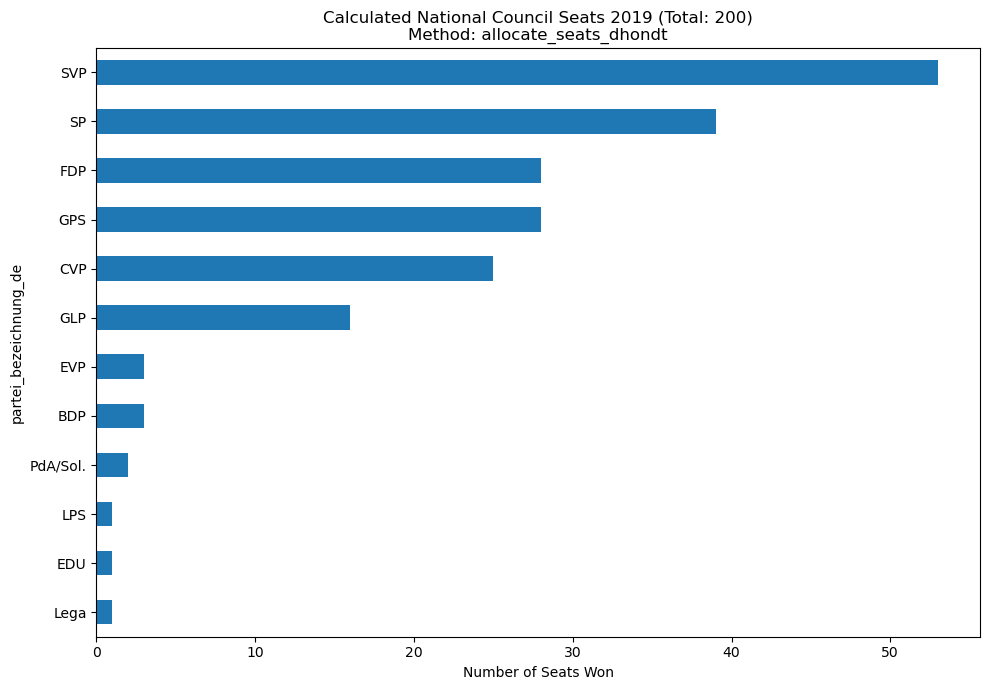

In [16]:
# This cell aggregates the calculated seats by party nationally and plots the distribution.

if calculated_seats_df.empty:
    print("\n--- National Results: No seats calculated. ---")
else:
    national_party_seats_calc = calculated_seats_df.groupby(
        ['partei_id', 'partei_bezeichnung_de']
    )['seats_won_calculated'].sum().reset_index().sort_values(by='seats_won_calculated', ascending=False)

    print("\n--- National Seat Distribution (Calculated) ---")
    print(national_party_seats_calc[['partei_bezeichnung_de', 'seats_won_calculated']].head(15))

    total_calc_seats = national_party_seats_calc['seats_won_calculated'].sum()
    expected_total_seats = sum(seats_per_canton_dict.values())
    print(f"\nTotal seats allocated (calculated): {total_calc_seats} / {expected_total_seats}")
    if total_calc_seats != expected_total_seats:
        print("WARNING: Mismatch in total allocated seats versus expected seats!")

    if not national_party_seats_calc.empty:
        plot_title = (f"Calculated National Council Seats {ELECTION_YEAR} (Total: {total_calc_seats})\n"
                      f"Method: {seat_allocator.__name__}")
        if 'adjusted_stimmen_partei' in lists_votes_processed.columns: # Check if simulation was run
            if not lists_votes_processed['votes_to_use'].equals(lists_votes_processed['stimmen_liste']):
                plot_title += " (100% Turnout Simulated)"

        national_party_seats_calc.set_index('partei_bezeichnung_de')['seats_won_calculated'].sort_values(ascending=True).plot(
            kind='barh',
            figsize=(10, 7),
            title=plot_title
        ).set_xlabel("Number of Seats Won")
        plt.tight_layout()
        plt.show()

In [17]:
# This cell compares the calculated seat distribution with the actual results
# from the 'anzahl_gewaehlte' column in the input 'lists_df'.

if calculated_seats_df.empty:
    print("\n--- Comparison: No calculated seats to compare. ---")
else:
    # Use original lists_year_original for actuals, as lists_votes_processed might be simulated
    actual_seats_from_lists = lists_year_original[lists_year_original['anzahl_gewaehlte'] > 0].groupby(
        ['partei_id', 'partei_bezeichnung_de']
    )['anzahl_gewaehlte'].sum().reset_index().rename(columns={'anzahl_gewaehlte': 'seats_won_actual'})

    comparison_df = pd.merge(
        national_party_seats_calc[['partei_id', 'partei_bezeichnung_de', 'seats_won_calculated']],
        actual_seats_from_lists[['partei_id', 'partei_bezeichnung_de', 'seats_won_actual']],
        on=['partei_id', 'partei_bezeichnung_de'],
        how='outer'
    ).fillna(0)

    comparison_df['seats_won_calculated'] = comparison_df['seats_won_calculated'].astype(int)
    comparison_df['seats_won_actual'] = comparison_df['seats_won_actual'].astype(int)
    comparison_df['difference'] = comparison_df['seats_won_calculated'] - comparison_df['seats_won_actual']

    print("\n--- Comparison: Calculated vs. Actual Seats (from 'anzahl_gewaehlte') ---")
    if (comparison_df['difference'] == 0).all():
        print("SUCCESS: Calculated seat distribution perfectly matches actuals from 'anzahl_gewaehlte'.")
        print(comparison_df[['partei_bezeichnung_de', 'seats_won_calculated', 'seats_won_actual']].head(10))
    else:
        print("Discrepancies found between calculated and actual seats:")
        print(comparison_df[['partei_bezeichnung_de', 'seats_won_calculated', 'seats_won_actual', 'difference']])

    total_actual_seats = comparison_df['seats_won_actual'].sum()
    print(f"Total actual seats from 'anzahl_gewaehlte': {total_actual_seats}")


--- Comparison: Calculated vs. Actual Seats (from 'anzahl_gewaehlte') ---
SUCCESS: Calculated seat distribution perfectly matches actuals from 'anzahl_gewaehlte'.
  partei_bezeichnung_de  seats_won_calculated  seats_won_actual
0                   FDP                    28                28
1                   CVP                    25                25
2                    SP                    39                39
3                   SVP                    53                53
4                   LPS                     1                 1
5                   EVP                     3                 3
6              PdA/Sol.                     2                 2
7                   GPS                    28                28
8                   EDU                     1                 1
9                  Lega                     1                 1
Total actual seats from 'anzahl_gewaehlte': 200
